In [ ]:
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import concatenate
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
(train_features, train_labels), (test_features, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
train_features = np.stack((train_features,) * 3, axis=-1)
test_features = np.stack((test_features,) * 3, axis=-1)

In [ ]:
train_features = np.array([np.array(Image.fromarray(img).resize((32,32), resample=Image.BILINEAR)) for img in train_features])
test_features = np.array([np.array(Image.fromarray(img).resize((32,32), resample=Image.BILINEAR)) for img in test_features])

In [ ]:
base_model = VGG16(include_top=False, input_shape=(32,32,3))

x = tf.keras.layers.Flatten()(base_model.output)
predictions = tf.keras.layers.Dense(10, activation='relu')(x)
# predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01), 
    loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           patience=3)

In [ ]:
model.fit(train_features, train_labels, epochs=99,
          batch_size=128, 
          validation_data=(test_features, test_labels),
          callbacks=[early_stopping_callback])

Epoch 1/99
469/469 [==============================] - 24s 24ms/step - loss: 0.9977 - accuracy: 0.7842 - val_loss: 0.5581 - val_accuracy: 0.8051
Epoch 2/99
469/469 [==============================] - 10s 22ms/step - loss: 0.4918 - accuracy: 0.8250 - val_loss: 0.5791 - val_accuracy: 0.8078
Epoch 3/99
469/469 [==============================] - 11s 23ms/step - loss: 0.4887 - accuracy: 0.8268 - val_loss: 0.5688 - val_accuracy: 0.8017
Epoch 4/99
469/469 [==============================] - 11s 23ms/step - loss: 0.4904 - accuracy: 0.8273 - val_loss: 0.5636 - val_accuracy: 0.8143


In [ ]:
train_groups = [train_features[np.where(train_labels==_)[0]] for _ in np.unique(train_labels)]
test_groups = [test_features[np.where(test_labels==_)[0]] for _ in np.unique(test_labels)]

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

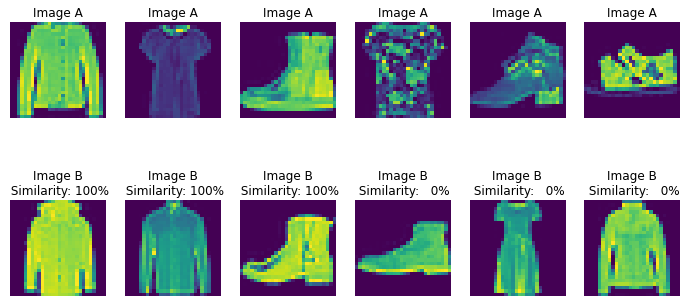

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [ ]:
img_a_in = tf.keras.layers.Input(shape = train_features.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = train_features.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

In [ ]:
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [ ]:
def find_simmilar(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    print(compiled[0].shape, compiled[1].shape)
    preds = siamese_model.predict(compiled).reshape(-1)
    print(preds.shape)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

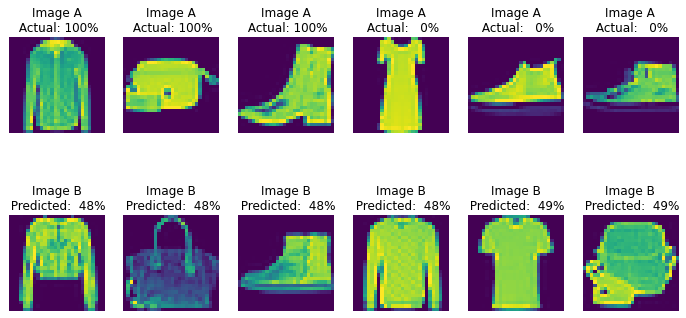

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 29s 54ms/step - loss: 0.6802 - mae: 0.4750 - val_loss: 0.5428 - val_mae: 0.4011
Epoch 2/10
500/500 [==============================] - 27s 54ms/step - loss: 0.5194 - mae: 0.3758 - val_loss: 0.3954 - val_mae: 0.2709
Epoch 3/10
500/500 [==============================] - 27s 54ms/step - loss: 0.4438 - mae: 0.3082 - val_loss: 0.3650 - val_mae: 0.2396
Epoch 4/10
500/500 [==============================] - 27s 53ms/step - loss: 0.4160 - mae: 0.2828 - val_loss: 0.3508 - val_mae: 0.2394
Epoch 5/10
500/500 [==============================] - 27s 53ms/step - loss: 0.3889 - mae: 0.2619 - val_loss: 0.3436 - val_mae: 0.2204
Epoch 6/10
500/500 [==============================] - 27s 54ms/step - loss: 0.3802 - mae: 0.2515 - val_loss: 0.3355 - val_mae: 0.2124
Epoch 7/10
500/500 [==============================] - 27s 54ms/step - loss: 0.3772 - mae: 0.2473 - val_loss: 0.3156 - val_mae: 0.2078
Epoch 8/10
500/500 [==============================] - 27s 54ms

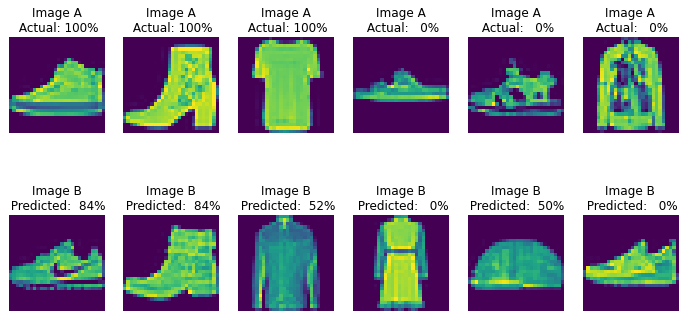

In [ ]:
_ = show_model_output()


In [ ]:
image = train_features[1488]

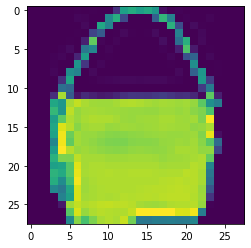

In [ ]:
plt.imshow(image[:, :, 0])

(1024, 28, 28, 1) (1024, 28, 28, 1)
(1024,)


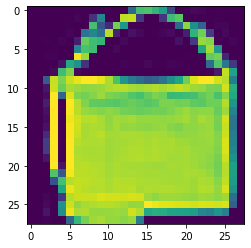

0.84206164


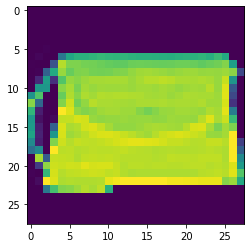

0.84206164


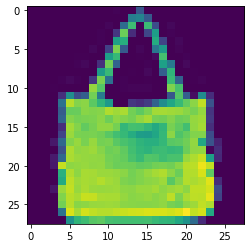

0.84206164


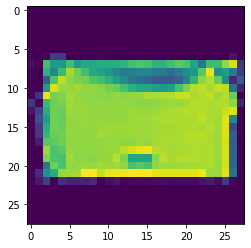

0.84206164


In [ ]:
find_simmilar(train_features, image)

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*test_features.shape[0], 0)
t_shirt_score = siamese_model.predict([t_shirt_vec, test_features], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*test_features.shape[0], 0)
ankle_boot_score = siamese_model.predict([ankle_boot_vec, test_features], verbose=True, batch_size=128)

79/79 [==============================] - 2s 21ms/step


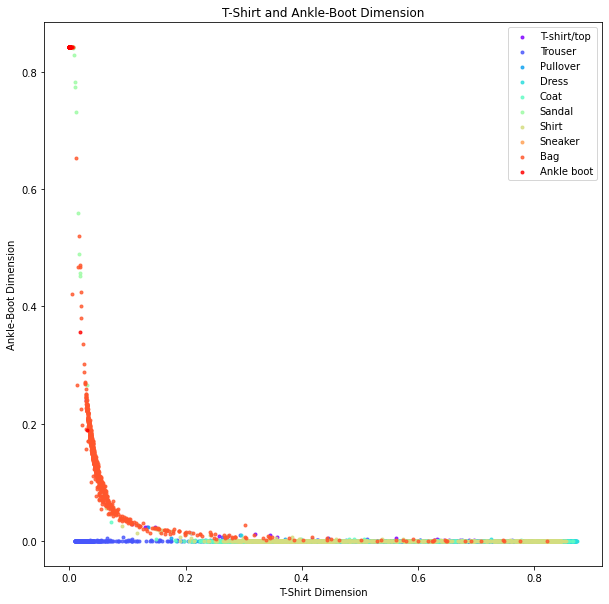

In [ ]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(test_labels == c_group), 0],
        ankle_boot_score[np.where(test_labels == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('dimension.png')

In [ ]:
x_test_features = model.predict(
    test_features,
    verbose=True,
    batch_size=128
)


79/79 [==============================] - 1s 13ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

c:\users\andrew\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.661s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.110160
[t-SNE] Computed conditional probabilities in 0.405s


c:\users\andrew\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 76.0196762, gradient norm = 0.0029489 (50 iterations in 2.735s)
[t-SNE] Iteration 100: error = 74.4684830, gradient norm = 0.0015873 (50 iterations in 2.581s)
[t-SNE] Iteration 150: error = 73.7582245, gradient norm = 0.0011637 (50 iterations in 2.681s)
[t-SNE] Iteration 200: error = 73.3521423, gradient norm = 0.0008506 (50 iterations in 2.631s)
[t-SNE] Iteration 250: error = 73.0897675, gradient norm = 0.0007246 (50 iterations in 2.711s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.089767
[t-SNE] Iteration 300: error = 2.5579820, gradient norm = 0.0012884 (50 iterations in 2.610s)
[t-SNE] Iteration 350: error = 2.0647645, gradient norm = 0.0005837 (50 iterations in 2.553s)
[t-SNE] Iteration 400: error = 1.8158860, gradient norm = 0.0003514 (50 iterations in 2.672s)
[t-SNE] Iteration 450: error = 1.6697613, gradient norm = 0.0002420 (50 iterations in 2.589s)
[t-SNE] Iteration 500: error = 1.5741593, gradient norm = 0.0001787 (50 

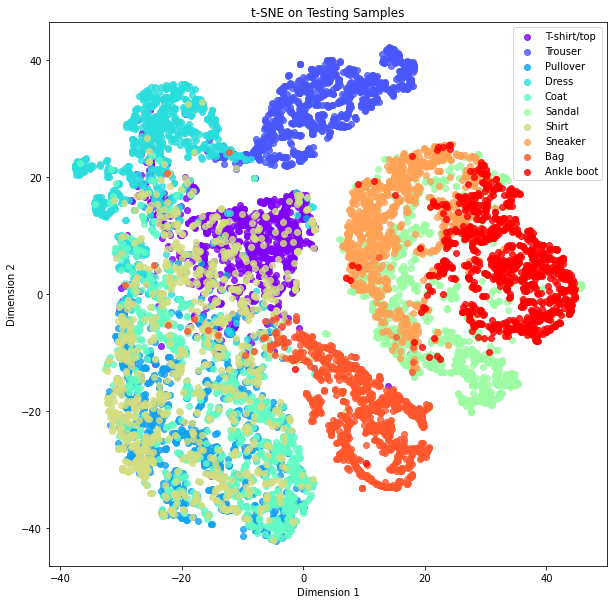

In [ ]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(test_labels == c_group), 0],
        tsne_features[np.where(test_labels == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)